<a href="https://colab.research.google.com/github/Inkering/Educational-Exploratory-Data-Analysis/blob/master/US_Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Education!

https://www.kaggle.com/noriuk/us-education-datasets-unification-project/data#

https://en.wikipedia.org/wiki/Partial_correlation partial correlation

## imports and downloads

In [0]:
import gdown
import pandas as pd

In [0]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1qno1ugZdSDLS4UnI89VpQZl2fVpbQO50&export=download', 'us-education-dataset.zip', False)


Downloading...
From: https://drive.google.com/uc?authuser=0&id=1qno1ugZdSDLS4UnI89VpQZl2fVpbQO50&export=download
To: /content/us-education-dataset.zip
91.6MB [00:01, 82.2MB/s]


'us-education-dataset.zip'

In [0]:
# Unzip datasets
!unzip -qq -o us-education-dataset.zip
#https://drive.google.com/file/d/1qno1ugZdSDLS4UnI89VpQZl2fVpbQO50/view?usp=sharing
#https://drive.google.com/drive/folders/1AsWUQORymT2BeCBVdyk5X8B5RA20d3Um?usp=sharing
#https://drive.google.com/file/d/1Z_rAAy-3UCK3yy-c9_Mxnx7Z34oxGwNL/view?usp=sharing

In [0]:
ls

aggregates/              nde/              states_all.csv
elsect/                  NDE/              states_all_extended.csv
enroll_sanity_check.txt  sample_data/      us-education-dataset.zip
nces_enroll/             sanity_check.txt


In [0]:
ls aggregates/Aggregates

enroll_states_base.csv  finance_districts.csv  naep_states_base.csv
enroll_states.csv       finance_states.csv     naep_states.csv


## Old- naep key

In [0]:
# naep_key = pd.read_csv("aggregates/Aggregates/naep_states.csv")
# naep_key

In [0]:
# naep_state_dict = dict()
# for i in range(len(naep_key['PRIMARY_KEY'])):
#   state_string = naep_key['PRIMARY_KEY'][i]
#   state_list = state_string.split('_')
#   year = state_list[0]
#   state = '_'.join(state_list[1:])
#   if state not in naep_state_dict.keys():
#     naep_state_dict[state] = year
#   else:
#     curr = naep_state_dict[state]
#     naep_state_dict[state] = curr + ' ' + year
# print(naep_state_dict)
#years of states are from 1992 to 2017

## Create Databases and Explore

"The extended version of states_all contains additional columns that breakdown enrollment by race and gender. For example:

Grades_ALL_AS: Number of students whose ethnicity was classified as "Asian".

Grades_ALL_ASM: Number of male students whose ethnicity was classified as "Asian".

Grades_ALL_ASF: Number of female students whose ethnicity was classified as "Asian".

The represented races include AM (American Indian or Alaska Native), AS (Asian), HI (Hispanic/Latino), BL (Black or African American), WH (White), HP (Hawaiian Native/Pacific Islander), and TR (Two or More Races). The represented genders include M (Male) and F (Female)."

In [0]:
states_full_key = pd.read_csv('states_all_extended.csv')
print(len(states_full_key))
print(states_full_key['PRIMARY_KEY'])
states_full_key.head()

1492
0             1992_ALABAMA
1              1992_ALASKA
2             1992_ARIZONA
3            1992_ARKANSAS
4          1992_CALIFORNIA
               ...        
1487         2017_VIRGINIA
1488       2017_WASHINGTON
1489    2017_WEST_VIRGINIA
1490        2017_WISCONSIN
1491          2017_WYOMING
Name: PRIMARY_KEY, Length: 1492, dtype: object


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,GRADES_PK_AM,GRADES_KG_AM,GRADES_4_AM,GRADES_8_AM,GRADES_12_AM,GRADES_1_8_AM,GRADES_9_12_AM,GRADES_ALL_AM,GRADES_PK_AS,GRADES_KG_AS,GRADES_4_AS,GRADES_8_AS,GRADES_12_AS,GRADES_1_8_AS,GRADES_9_12_AS,GRADES_ALL_AS,GRADES_PK_HI,GRADES_KG_HI,GRADES_4_HI,...,GRADES_12_WHF,GRADES_1_8_WHF,GRADES_9_12_WHF,GRADES_ALL_WHF,GRADES_PK_HPM,GRADES_KG_HPM,GRADES_4_HPM,GRADES_8_HPM,GRADES_12_HPM,GRADES_1_8_HPM,GRADES_9_12_HPM,GRADES_ALL_HPM,GRADES_PK_HPF,GRADES_KG_HPF,GRADES_4_HPF,GRADES_8_HPF,GRADES_12_HPF,GRADES_1_8_HPF,GRADES_9_12_HPF,GRADES_ALL_HPF,GRADES_PK_TRM,GRADES_KG_TRM,GRADES_4_TRM,GRADES_8_TRM,GRADES_12_TRM,GRADES_1_8_TRM,GRADES_9_12_TRM,GRADES_ALL_TRM,GRADES_PK_TRF,GRADES_KG_TRF,GRADES_4_TRF,GRADES_8_TRF,GRADES_12_TRF,GRADES_1_8_TRF,GRADES_9_12_TRF,GRADES_ALL_TRF,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,735036.0,NaN,174053.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,NaN,172.0,460.0,625.0,446.0,3930.0,2069.0,NaN,NaN,307.0,346.0,306.0,249.0,2651.0,1156.0,NaN,NaN,220.0,173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,350902.0,NaN,37451.0,2371.0,10152.0,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,1457.0,2624.0,2175.0,1853.0,1323.0,17664.0,6391.0,25512.0,55.0,395.0,389.0,367.0,324.0,3090.0,1350.0,4495.0,26.0,229.0,204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,1007732.0,NaN,609114.0,2544.0,53497.0,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,250.0,3674.0,3946.0,3230.0,2234.0,30133.0,10686.0,41069.0,20.0,754.0,822.0,734.0,823.0,6446.0,3340.0,9806.0,718.0,15501.0,14877.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,483488.0,NaN,145212.0,808.0,33511.0,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,2.0,84.0,84.0,146.0,67.0,828.0,382.0,1212.0,7.0,199.0,214.0,216.0,224.0,1792.0,902.0,2701.0,11.0,370.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,8520926.0,NaN,2044688.0,59067.0,431763.0,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,NaN,2954.0,3079.0,2912.0,2434.0,24697.0,12820.0,NaN,NaN,41763.0,46079.0,40852.0,39036.0,356001.0,169604.0,NaN,NaN,170998.0,152087.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.398961,260.892247,196.764414,NaN


In [0]:
full_states_dict = dict()
states_1992_revenue_dict = dict()
for i in range(len(states_full_key['PRIMARY_KEY'])):
  state_string = states_full_key['PRIMARY_KEY'][i]
  state_list = state_string.split('_')
  year = state_list[0]
  state = '_'.join(state_list[1:])
  if state not in full_states_dict.keys():
    full_states_dict[state] = year
  else:
    curr = full_states_dict[state]
    full_states_dict[state] = curr + ' ' + year
print(full_states_dict)

{'ALABAMA': '1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017', 'ALASKA': '1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017', 'ARIZONA': '1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017', 'ARKANSAS': '1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017', 'CALIFORNIA': '1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017', 'COLORADO': '1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017', 'CONNECTICUT': '1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 

## Useful functions for database indexing

In [0]:
states_full_key['PRIMARY_KEY'][1]

'1992_ALASKA'

In [0]:
states_full_key.iloc[0]

PRIMARY_KEY            1992_ALABAMA
STATE                       ALABAMA
YEAR                           1992
ENROLL                          NaN
TOTAL_REVENUE           2.67888e+06
                           ...     
GRADES_ALL_TRF                  NaN
AVG_MATH_4_SCORE            208.328
AVG_MATH_8_SCORE            252.188
AVG_READING_4_SCORE         207.964
AVG_READING_8_SCORE             NaN
Name: 0, Length: 193, dtype: object

## Databases for exploring correlations

To visualize revenues and scores for states (year 1992):

In [0]:
#states_full_key[(states_full_key['YEAR'] == 1992)] gets all rows where year == 1992
revs_1992 = states_full_key[(states_full_key['YEAR'] == 1992)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE','GRADES_8_G']]
print(revs_1992.head())
revs_2005 = states_full_key[(states_full_key['YEAR'] == 2005)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE','GRADES_8_G']]
print(revs_2005.head())

      STATE  TOTAL_REVENUE  AVG_MATH_8_SCORE  GRADES_8_G
0   ALABAMA      2678885.0        252.187522     58025.0
1    ALASKA      1049591.0               NaN      8789.0
2   ARIZONA      3258079.0        265.366278     49081.0
3  ARKANSAS      1711959.0        256.312090     36011.0
5  COLORADO      3185173.0        272.398433     45025.0
                    STATE  TOTAL_REVENUE  AVG_MATH_8_SCORE  GRADES_8_G
664                ALASKA      1599739.0        278.958709     10793.0
666              ARKANSAS      3978240.0        271.636348     37279.0
670              DELAWARE      1431710.0        280.953543     10492.0
671  DISTRICT_OF_COLUMBIA      1109605.0        245.215781      5196.0
674                HAWAII      2274166.0        265.629319     13696.0


Add a column for revenue per students

In [0]:
def per_student(total, enrolled):
  return total/enrolled
revs_1992['REVENUE_PER_STUDENT'] =  list(map(per_student, revs_1992['TOTAL_REVENUE'],revs_1992['GRADES_8_G']))
#print(revs_1992.head())
revs_2005['REVENUE_PER_STUDENT'] =  list(map(per_student, revs_2005['TOTAL_REVENUE'],revs_2005['GRADES_8_G']))
#print(revs_2005.head())

Create a database to store race percent/demographics for schools

The represented races include AM (American Indian or Alaska Native), AS (Asian), HI (Hispanic/Latino), BL (Black), WH (White), HP (Pacific Islander), and TR (Two or More Races)

In [0]:
#To see what columns hold data
states_full_key[(states_full_key['YEAR'] == 1992)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','GRADES_8_AS', 'GRADES_8_BL','GRADES_8_AM', 'GRADES_8_WH','GRADES_8_HI','GRADES_8_HP', 'GRADES_8_TR']].head()

,STATE,GRADES_8_AS,GRADES_8_BL,GRADES_8_AM,GRADES_8_WH,GRADES_8_HI,GRADES_8_HP,GRADES_8_TR
0,ALABAMA,306.0,20816.0,625.0,35854.0,164.0,NaN,NaN
1,ALASKA,367.0,422.0,1853.0,5965.0,182.0,NaN,NaN
2,ARIZONA,734.0,1888.0,3230.0,30265.0,12964.0,NaN,NaN
3,ARKANSAS,216.0,8828.0,146.0,26588.0,233.0,NaN,NaN
5,COLORADO,969.0,2361.0,408.0,33892.0,7395.0,NaN,NaN


Based on this representation of the table, white(WH), Black(BL), native americans(AM),asian(AS), and hispanic(HI) demographics exist

In [0]:
revs_demo_1992 = states_full_key[(states_full_key['YEAR'] == 1992)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE', 'GRADES_8_BL','GRADES_8_AS','GRADES_8_HI','GRADES_8_AM','GRADES_8_WH','GRADES_8_G']]
print(revs_demo_1992.head())
revs_demo_2005 = states_full_key[(states_full_key['YEAR'] == 2005)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE', 'GRADES_8_BL','GRADES_8_AS','GRADES_8_HI','GRADES_8_AM','GRADES_8_WH','GRADES_8_G']]
print(revs_demo_2005.head())
revs_demo_2015 = states_full_key[(states_full_key['YEAR'] == 2015)&(states_full_key['TOTAL_REVENUE'] <= 5000000)][['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE', 'GRADES_8_BL','GRADES_8_AS','GRADES_8_HI','GRADES_8_AM','GRADES_8_WH','GRADES_8_G']]
print(revs_demo_2015.head())

      STATE  TOTAL_REVENUE  ...  GRADES_8_WH  GRADES_8_G
0   ALABAMA      2678885.0  ...      35854.0     58025.0
1    ALASKA      1049591.0  ...       5965.0      8789.0
2   ARIZONA      3258079.0  ...      30265.0     49081.0
3  ARKANSAS      1711959.0  ...      26588.0     36011.0
5  COLORADO      3185173.0  ...      33892.0     45025.0

[5 rows x 9 columns]
                    STATE  TOTAL_REVENUE  ...  GRADES_8_WH  GRADES_8_G
664                ALASKA      1599739.0  ...       6243.0     10793.0
666              ARKANSAS      3978240.0  ...      25807.0     37279.0
670              DELAWARE      1431710.0  ...       5693.0     10492.0
671  DISTRICT_OF_COLUMBIA      1109605.0  ...        125.0      5196.0
674                HAWAII      2274166.0  ...       2593.0     13696.0

[5 rows x 9 columns]
                     STATE  TOTAL_REVENUE  ...  GRADES_8_WH  GRADES_8_G
1179                ALASKA      2920986.0  ...       4544.0      9400.0
1185              DELAWARE      2017075.0  .

In [0]:
def race_percent(num_race, total):
  if num_race == None or total == None:
    return 0
  else:
    return float(num_race)/float(total)

# for each racial demographic calculate percent
revs_demo_1992['AS_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_AS'],revs_demo_1992['GRADES_8_G']))
revs_demo_1992['BL_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_BL'],revs_demo_1992['GRADES_8_G']))
revs_demo_1992['AM_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_AM'],revs_demo_1992['GRADES_8_G']))
revs_demo_1992['WH_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_WH'],revs_demo_1992['GRADES_8_G']))
revs_demo_1992['HI_PER'] =  list(map(race_percent, revs_demo_1992['GRADES_8_HI'],revs_demo_1992['GRADES_8_G']))
# get rid of unnecessary rows to have small database
revs_demo_1992 = revs_demo_1992[['STATE','TOTAL_REVENUE','AVG_MATH_8_SCORE', 'AS_PER','BL_PER','AM_PER','WH_PER','HI_PER']]
revs_demo_1992.head()
# need to grab a specific year for this to work i think]

,STATE,TOTAL_REVENUE,AVG_MATH_8_SCORE,AS_PER,BL_PER,AM_PER,WH_PER,HI_PER
0,ALABAMA,2678885.0,252.187522,0.005274,0.358742,0.010771,0.617906,0.002826
1,ALASKA,1049591.0,NaN,0.041757,0.048015,0.210832,0.678689,0.020708
2,ARIZONA,3258079.0,265.366278,0.014955,0.038467,0.065810,0.616634,0.264135
3,ARKANSAS,1711959.0,256.312090,0.005998,0.245147,0.004054,0.738330,0.006470
5,COLORADO,3185173.0,272.398433,0.021521,0.052438,0.009062,0.752737,0.164242


## Plots of correlations

These plots look at the correlation between a variable and test scores. For now, this is just on 1992 and 2005 data and 8th graders. The test scores are math scores.

### Demographic

white(WH), Black(BL), native americans(AM),asian(AS), and hispanic(HI)

In [0]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

In [0]:
# plt.scatter(revs_demo_1992['WH_PER'], revs_1992['AVG_MATH_8_SCORE'])
# plt.scatter(revs_demo_1992['BL_PER'], revs_1992['AVG_MATH_8_SCORE'])
# plt.scatter(revs_demo_1992['HI_PER'], revs_1992['AVG_MATH_8_SCORE'])
# plt.scatter(revs_demo_1992['AS_PER'], revs_1992['AVG_MATH_8_SCORE'])
# plt.scatter(revs_demo_1992['AM_PER'], revs_1992['AVG_MATH_8_SCORE'])

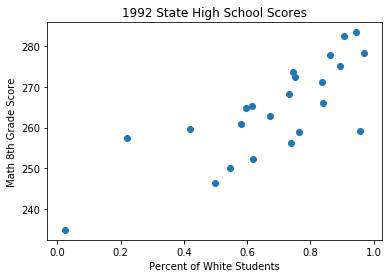

In [0]:
plt.scatter(revs_demo_1992['WH_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of White Students')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

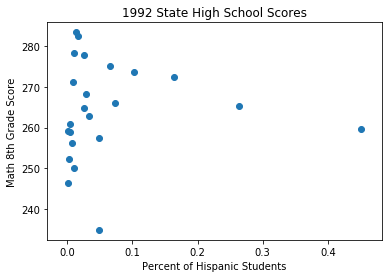

In [0]:
plt.scatter(revs_demo_1992['HI_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of Hispanic Students')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

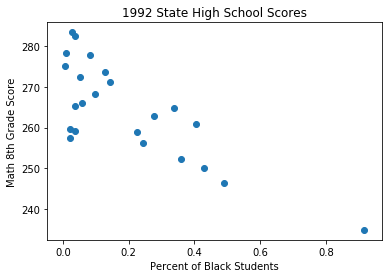

In [0]:
plt.scatter(revs_demo_1992['BL_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of Black Students')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

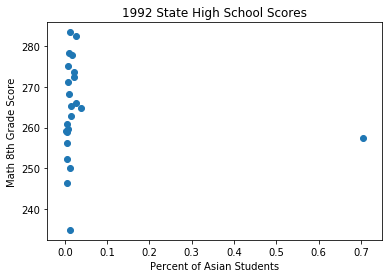

In [0]:
plt.scatter(revs_demo_1992['AS_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of Asian Students')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

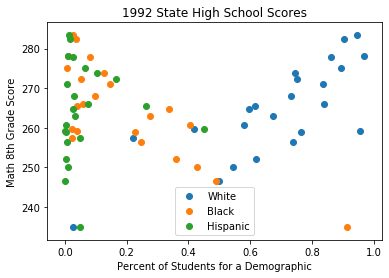

In [0]:
plt.scatter(revs_demo_1992['WH_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.scatter(revs_demo_1992['BL_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.scatter(revs_demo_1992['HI_PER'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Percent of Students for a Demographic')
plt.ylabel('Math 8th Grade Score')
plt.title('1992 State High School Scores')
plt.legend(('White','Black','Hispanic'))

plt.show()

### Revenue per student and number of students

revenue per student vs. scores graphs

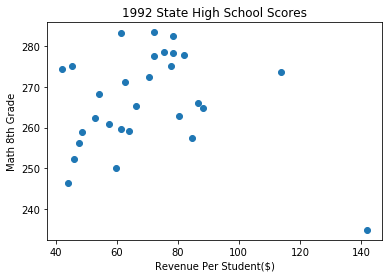

In [0]:
plt.scatter(revs_1992['REVENUE_PER_STUDENT'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Revenue Per Student($)')
plt.ylabel('Math 8th Grade')
plt.title('1992 State High School Scores')

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

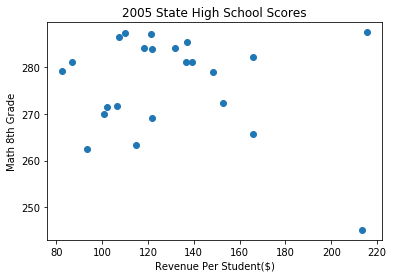

In [0]:
plt.scatter(revs_2005['REVENUE_PER_STUDENT'], revs_2005['AVG_MATH_8_SCORE'])
plt.xlabel('Revenue Per Student($)')
plt.ylabel('Math 8th Grade')
plt.title('2005 State High School Scores')

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

number of students vs. grades graphs

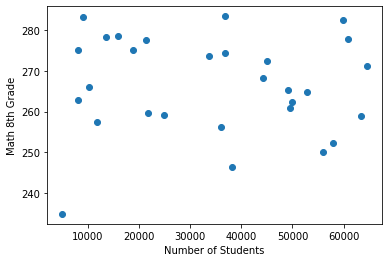

In [0]:
plt.scatter(revs_1992['GRADES_8_G'], revs_1992['AVG_MATH_8_SCORE'])
plt.xlabel('Number of Students')
plt.ylabel('Math 8th Grade')

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

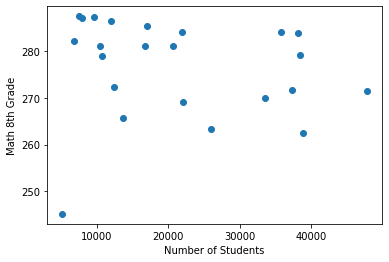

In [0]:
plt.scatter(revs_2005['GRADES_8_G'], revs_2005['AVG_MATH_8_SCORE'])
plt.xlabel('Number of Students')
plt.ylabel('Math 8th Grade')

#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### other plots

In [0]:
# from matplotlib.lines import Line2D
# import matplotlib.pyplot as plt
# %matplotlib inline
# from matplotlib.ticker import FormatStrFormatter

# plt.scatter(revs_1992['STATE'], revs_1992['TOTAL_REVENUE'])
# plt.xlabel('State')
# plt.ylabel('Total Revenue ($)')

# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
# plt.show()

In [0]:
#can be helpful just to see what states make most revenue
# plt.scatter(revs_2005['STATE'], revs_2005['TOTAL_REVENUE'])
# plt.xlabel('State')
# plt.ylabel('Total Revenue ($)')
# plt.title('1992 State High School Scores')

# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
# plt.show()

In [0]:
#no correlation, then decided to do it per student
# plt.scatter(revs_1992['TOTAL_REVENUE'], revs_1992['AVG_MATH_8_SCORE'])
# plt.xlabel('Total Revenue ($)')
# plt.ylabel('Math 8th Grade')

# #plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
# plt.show()

In [0]:
# plt.scatter(revs_2005['TOTAL_REVENUE'], revs_2005['AVG_MATH_8_SCORE'])
# plt.xlabel('Total Revenue ($)')
# plt.ylabel('Math 8th Grade')
# plt.title('2005 State High School Scores')

# #plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
# plt.show()

In [0]:
#states_full_key.loc[['1992_ALABAMA','1992'],['PRIMARY_KEY','YEAR']]

## Other stuff

In [0]:
ls sample_data/

anscombe.json*                mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md*


In [0]:
test = pd.read_csv('sample_data/mnist_train_small.csv')
test.head()

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
